In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import h5py

import sys
sys.path.append('../')
import analysis_utils as utils
utils.load_plotting_setting()

from scipy.signal import welch
from scipy.optimize import curve_fit

from scipy.fft import rfft, irfft, rfftfreq

In [2]:
import importlib
importlib.reload(utils)

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/gas_collisiions/analysis_notebooks/../analysis_utils.py'>

In [3]:
sphere = 'sphere_20260105'
dataset = '20260107_p8e_4e-8mbar_d137khz_0'
data_prefix = '20260107_dfg_p8e_200ns_'

data_folder = rf'/Volumes/LaCie/gas_collisions/pulse_calibration/{sphere}/{dataset}'

In [60]:
def read_recon(voltages, dataset):
    file = rf'/Users/yuhan/work/nanospheres/gas_collisiions/data_processed/pulse_calibration/{dataset}_processed.hdf5'

    amps_all, pulse_shapes_all, zz_pulses_all, drive_area_all, f_res_all = [], [], [], [], []
    f = h5py.File(file, 'r')
    for v in voltages:
        amps = f['data_processed'][f'amplitudes_{v}v'][:]
        ps = f['data_processed'][f'pulse_shapes_{v}v'][:]
        zz = f['data_processed'][f'z_signal_{v}v'][:]
        drive_area = f['data_processed'][f'drive_area_{v}v'][:]
        f_res = f['data_processed'][f'f_res_{v}v'][:]

        amps_all.append(amps)
        pulse_shapes_all.append(ps)
        zz_pulses_all.append(zz)
        drive_area_all.append(drive_area)
        f_res_all.append(f_res)

    amps_noise = f['data_processed'][f'amplitudes_noise_2.5v'][:]
    amps_noise_search = f['data_processed'][f'amplitudes_noise_search_2.5v'][:]
    f.close()

    return amps_all, amps_noise, amps_noise_search, pulse_shapes_all, zz_pulses_all, drive_area_all, f_res_all


In [74]:
amp2kev = 6792.86423779262
c_mv = 3.620829311453009e-07
voltages = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]

dataset_0 = '20260107_p8e_4e-8mbar_d137khz_0'
amps_all, amps_noise, amps_noise_search, pulse_shapes_all, zz_pulses_all, drive_area_all, f_res_all = read_recon(voltages, dataset_0)

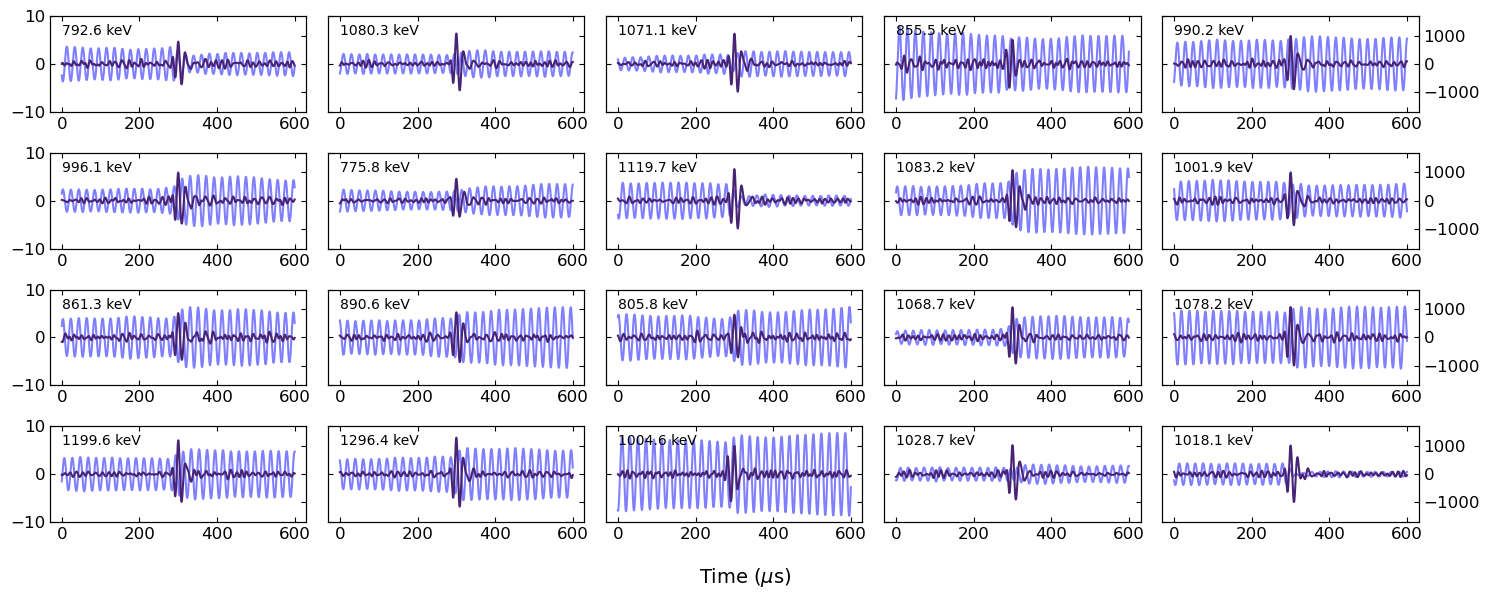

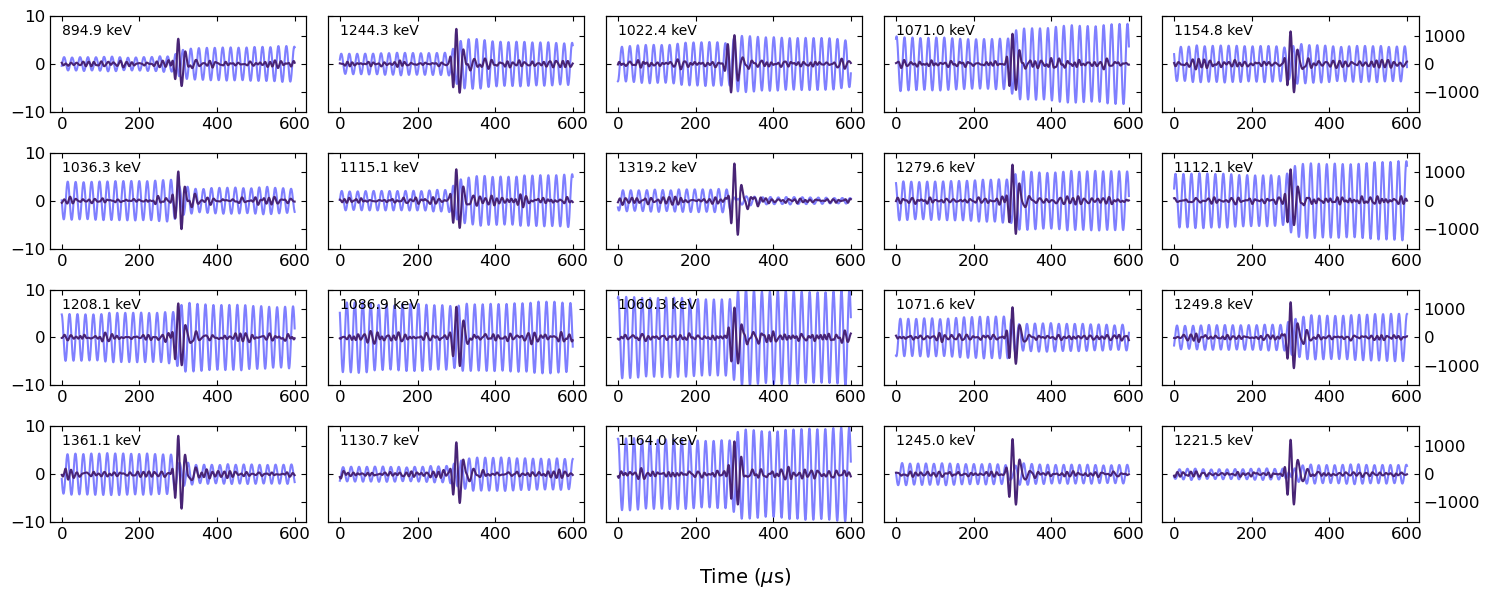

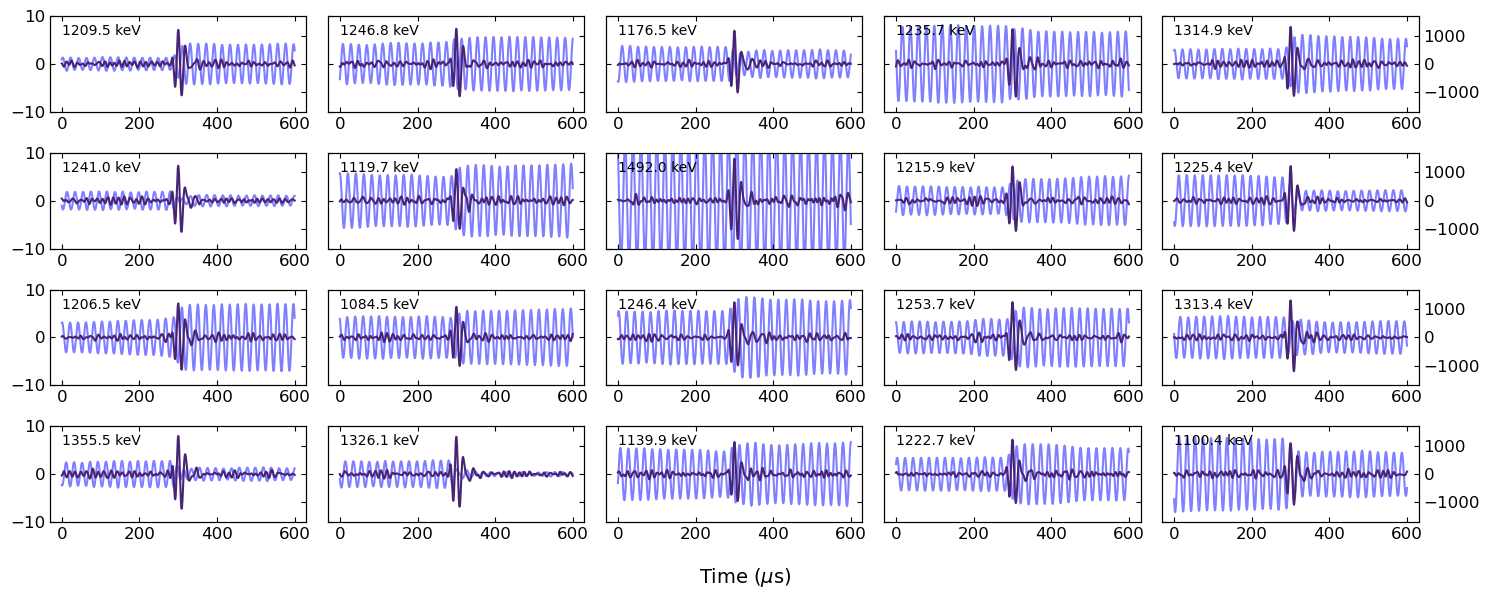

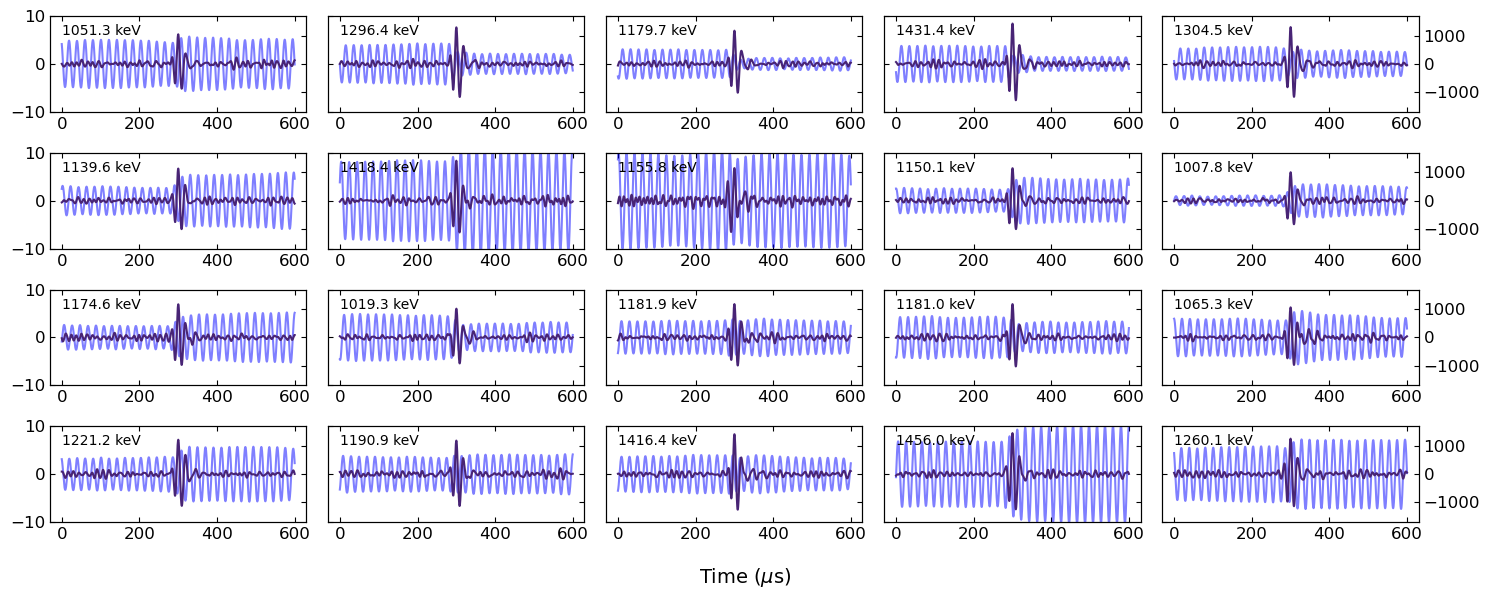

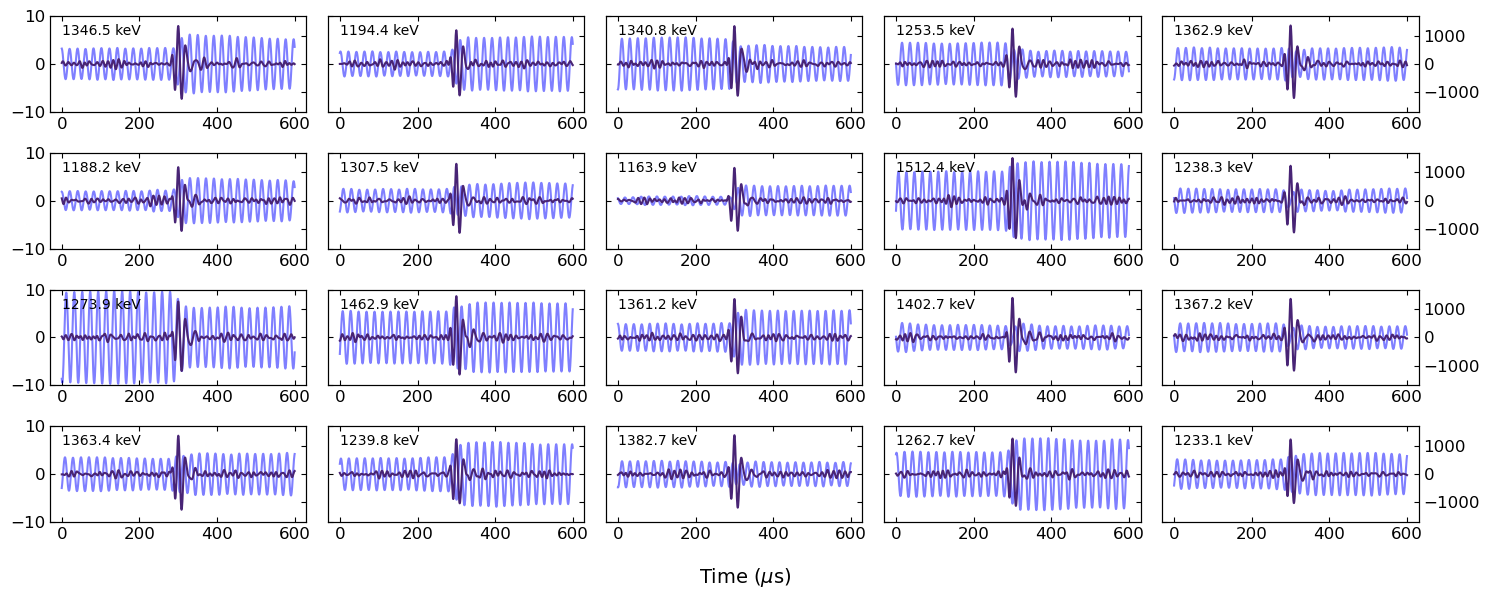

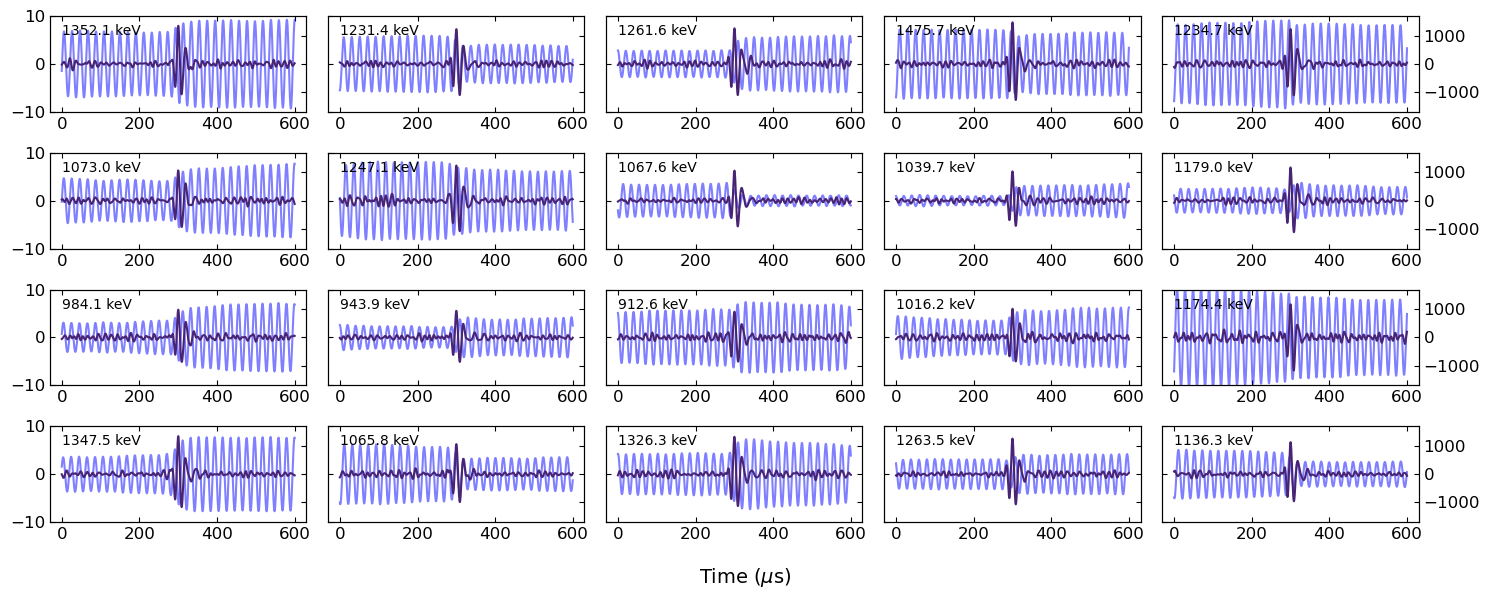

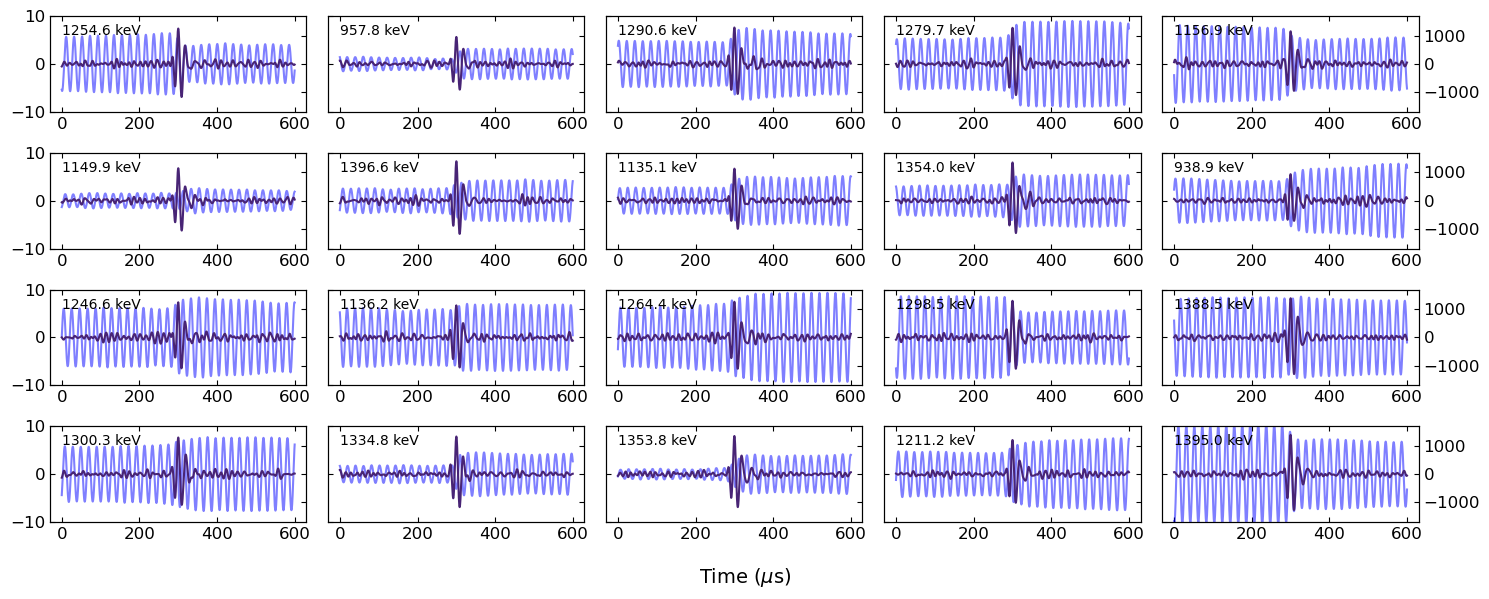

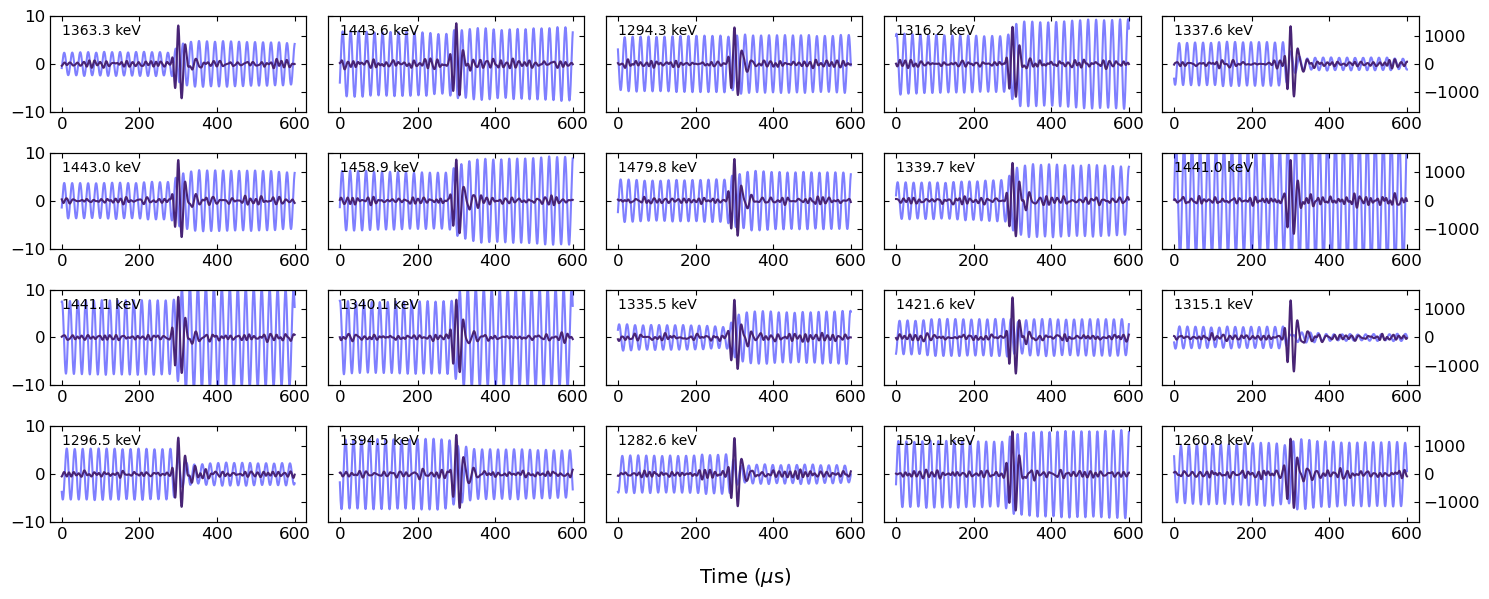

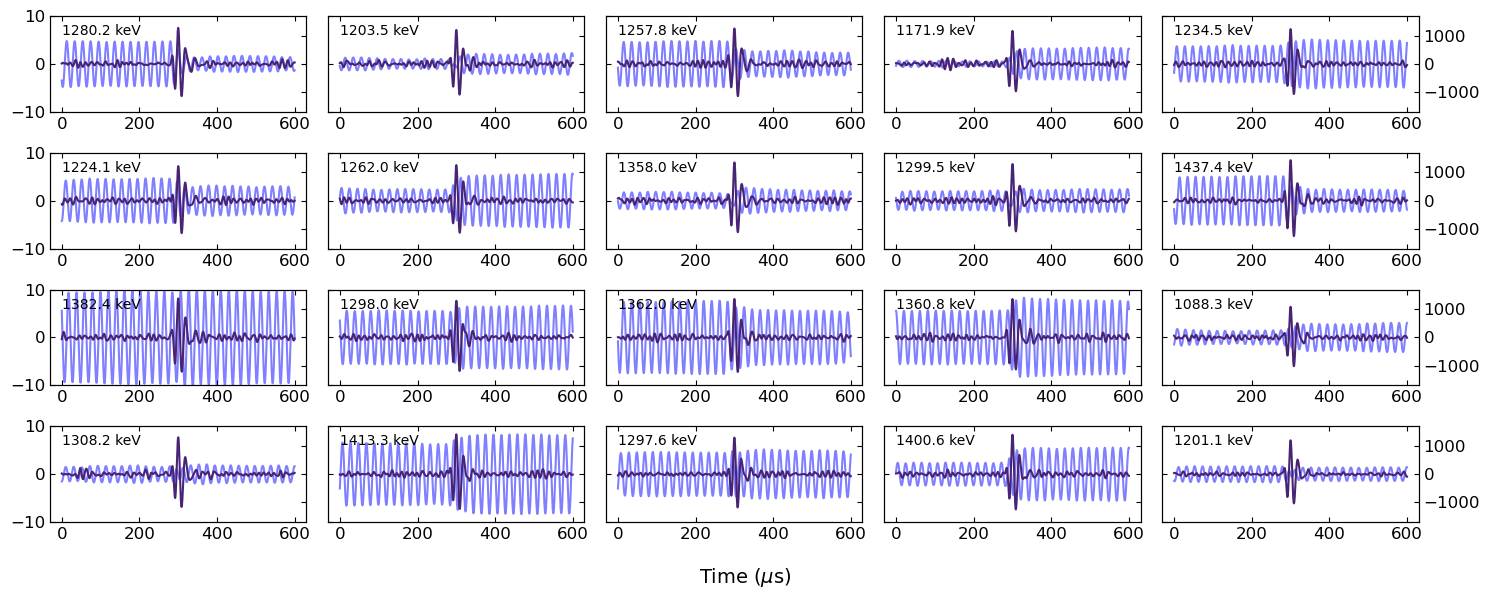

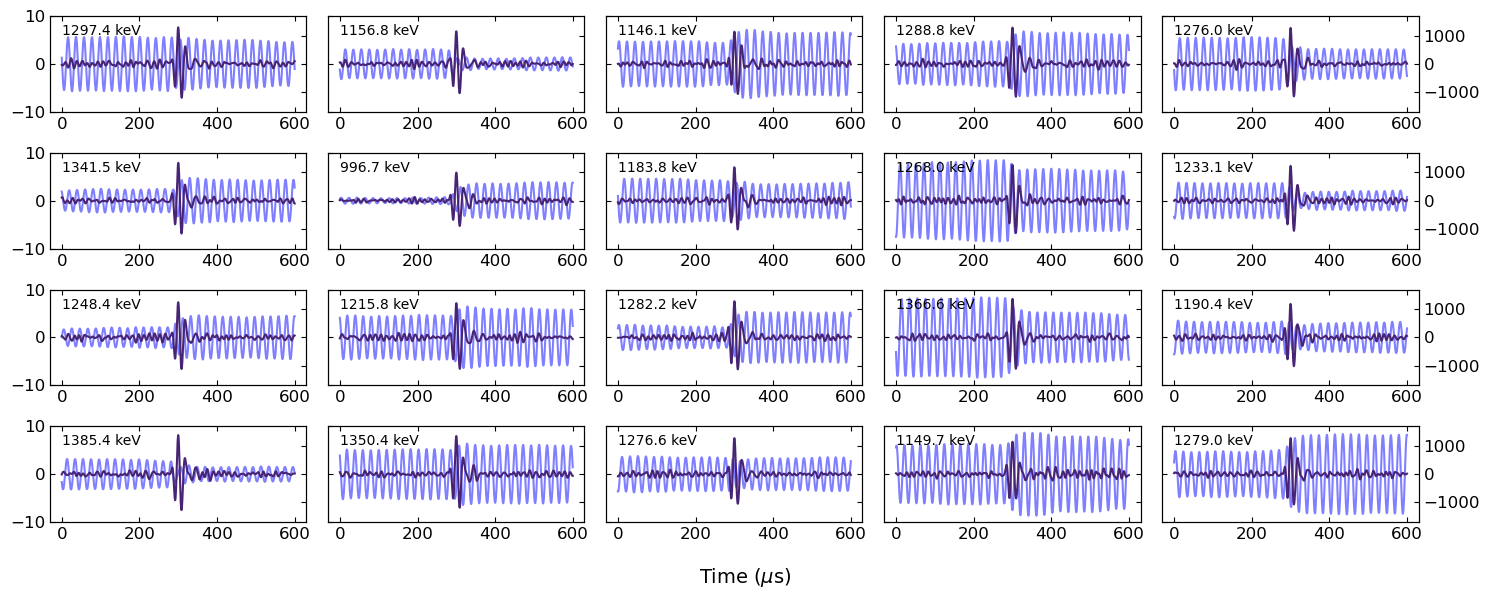

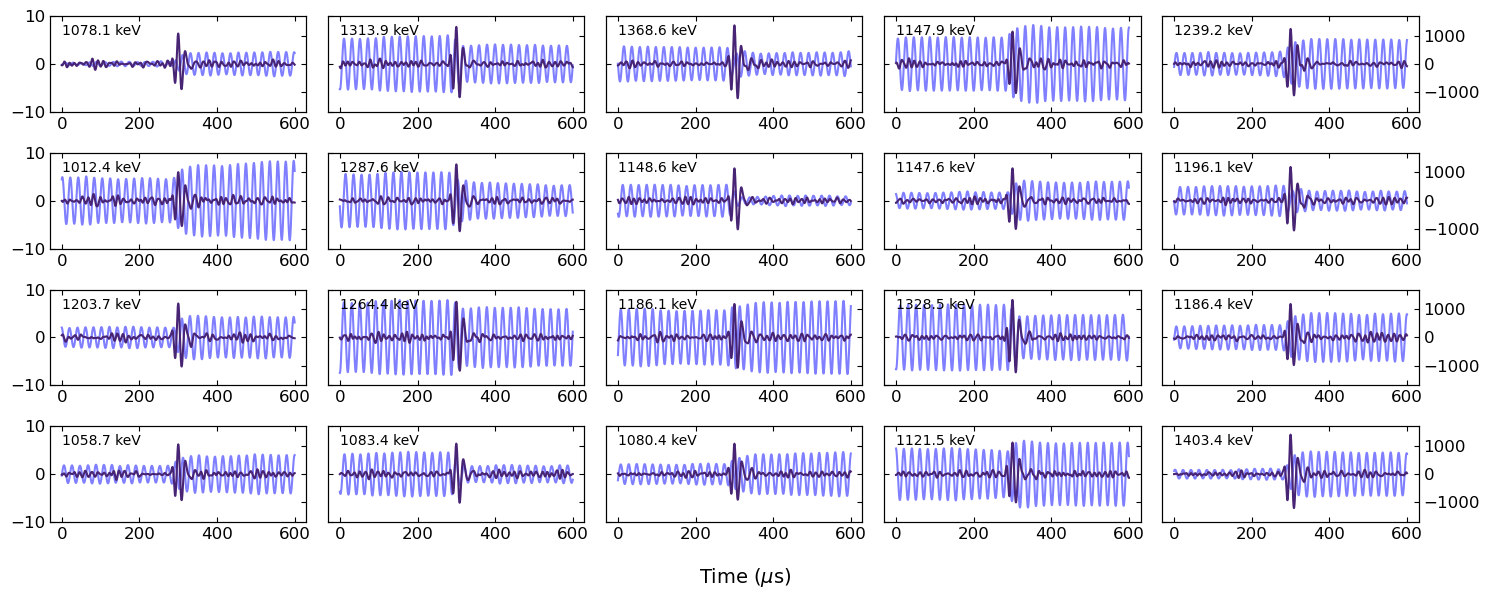

In [62]:
for j in range(11):

    fig, axes = plt.subplots(4, 5, figsize=(15, 6))
    for i in range(20):
        ax = axes[i//5][i%5]
        ax1 = ax.twinx()

        if i%5 != 4:
            ax1.set_yticklabels([])
        if i%5 != 0:
            ax.set_yticklabels([])
        
        tt = 200e-9/1e-6 * np.arange(zz_pulses_all[7][i+20*j].size)
        ax.text(0, 6, f'{amps_all[7][i+20*j]*amp2kev:.1f} keV', fontsize=10)
        ax.plot(tt, c_mv * zz_pulses_all[7][i+20*j]/1e-9, 'b', alpha=0.5)
        ax1.plot(tt, pulse_shapes_all[7][i+20*j] * amp2kev)
        ax.set_ylim(-10, 10)
        ax1.set_ylim(-1700, 1700)

    fig.supxlabel(r'Time ($\mu$s)', fontsize=14)
    fig.tight_layout()
    plt.plot()


In [75]:
bins = np.linspace(0.5e-8, 2.5e-8, 150)
# bins = np.linspace(0, 1.05, 150)
bc = 0.5 * (bins[1:] + bins[:-1])

_drive = np.concatenate(drive_area_all)
_freq = np.concatenate(f_res_all)

drive_freq = 137000
ref_freq = 48500
normalized_drive_area = _drive * (_freq**2 - drive_freq**2)**2 / ((ref_freq**2 - drive_freq**2)**2)

# hh_nonorm, _ = np.histogram(_drive, bins=bins)
hh, _ = np.histogram(normalized_drive_area, bins=bins)

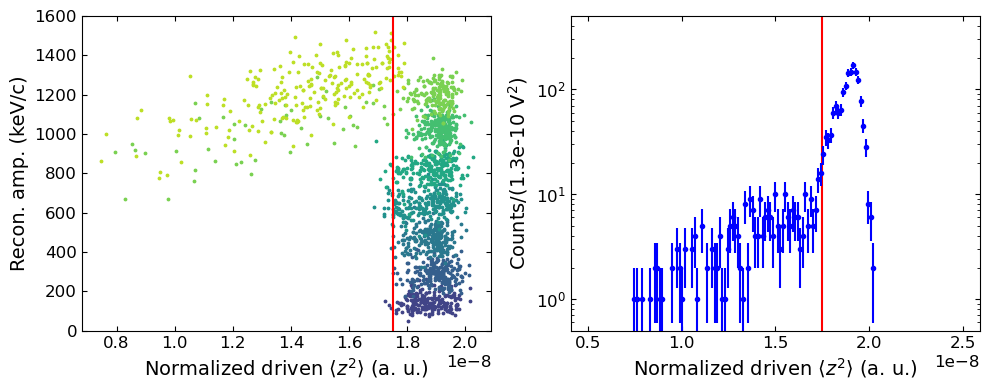

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
cmap = plt.colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0.2, 0.9, 8))

for i in range(8):
    norm = drive_area_all[i] * (f_res_all[i]**2 - drive_freq**2)**2 / ((ref_freq**2 - drive_freq**2)**2)
    axes[0].plot(norm, amps_all[i]*amp2kev, '.', color=colors[i], markersize=3.5)

cut_threshold = 1.75e-8
axes[0].vlines(cut_threshold, 0, 1600, 'r')
axes[1].vlines(cut_threshold, 1e-1, 1000, 'r')
axes[1].errorbar(bc, hh, yerr=np.sqrt(hh), fmt='.', color='b', alpha=1)

axes[0].set_ylim(0, 1600)
axes[0].set_xlabel(r'Normalized driven $\langle z^2 \rangle$ (a. u.)')
axes[0].set_ylabel(r'Recon. amp. (keV/c)')

axes[1].set_ylim(5e-1, 5e2)
axes[1].set_yscale('log')
axes[1].set_xlabel(r'Normalized driven $\langle z^2 \rangle$ (a. u.)')
axes[1].set_ylabel(rf'Counts/({bc[1]-bc[0]:.1e} V$^2$)')

fig.tight_layout()

In [77]:
def get_good_amps(amps_all, pulse_shapes_all, drive_area_all, f_res_all, drive_freq, ref_freq, threshold):
    good_amps, good_pulses = [], []
    for i, drive_area in enumerate(drive_area_all):
        normalized_drive_area = drive_area * (f_res_all[i]**2 - drive_freq**2)**2 / ((ref_freq**2 - drive_freq**2)**2)
        good_amps.append(amps_all[i][normalized_drive_area > threshold])
        good_pulses.append(pulse_shapes_all[i][normalized_drive_area > threshold])


    return good_amps, good_pulses


Text(0, 0.5, 'Counts/(25 keV/c)')

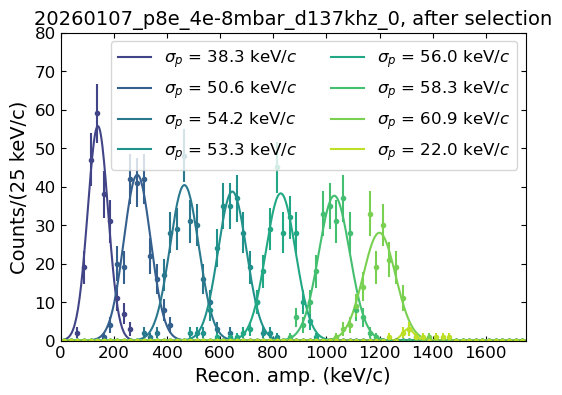

In [78]:
good_amps_all, _ = get_good_amps(amps_all, pulse_shapes_all, drive_area_all, f_res_all, 137000, 48500, 1.75e-8)

bins = np.arange(0, 3000, 25) / amp2kev

cmap = plt.colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0.2, 0.9, 8))
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

hhs, bcs, gps = utils.fit_amps_gaus(amps_all, bins=bins, noise=False, return_bins=False)
hhs_good, bcs_good, gps_good = utils.fit_amps_gaus(good_amps_all, bins=bins, noise=False, return_bins=False)

xx = np.linspace(0, np.max(bcs[0]), 1000)
for i, amps in enumerate(good_amps_all):
    if amps.size == 0:
        continue
    # ax.errorbar(bcs[i]*amp2kev, hhs[i], yerr=np.sqrt(hhs[i]), fmt='.', color=colors[i])
    # ax.plot(xx*amp2kev, utils.gauss(xx, *gps[i]), label=fr'$\sigma_p$ = {gps[i][2]*amp2kev:.1f} keV/$c$', color=colors[i])
    ax.errorbar(bcs[i]*amp2kev, hhs_good[i], yerr=np.sqrt(hhs_good[i]), fmt='.', color=colors[i])
    ax.plot(xx*amp2kev, utils.gauss(xx, *gps_good[i]), label=fr'$\sigma_p$ = {gps_good[i][2]*amp2kev:.1f} keV/$c$', color=colors[i])

ax.set_title('20260107_p8e_4e-8mbar_d137khz_0, after selection')
ax.legend(ncol=2)
ax.set_xlim(0, 1750)
ax.set_ylim(0, 80)
ax.set_xlabel('Recon. amp. (keV/c)')
ax.set_ylabel('Counts/(25 keV/c)')

#### Now look at all calibration datasets

In [67]:
def plot_monitoring(dataset, drive_area_all, amps_all, f_res_all, drive_freq, ref_freq, amp2kev):
    cmap = plt.colormaps.get_cmap('viridis')
    colors = cmap(np.linspace(0.2, 0.9, 8))

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    for i in range(8):
        norm = drive_area_all[i] * (f_res_all[i]**2 - drive_freq**2)**2 / ((ref_freq**2 - drive_freq**2)**2)
        axes[0].plot(norm, amps_all[i]*amp2kev, '.', color=colors[i], markersize=3.5)

    bins = np.linspace(0.5e-8, 2.5e-8, 150)
    bc = 0.5 * (bins[1:] + bins[:-1])

    _drive = np.concatenate(drive_area_all)
    _freq = np.concatenate(f_res_all)

    drive_freq = 137000
    ref_freq = 48500
    normalized_drive_area = _drive * (_freq**2 - drive_freq**2)**2 / ((ref_freq**2 - drive_freq**2)**2)

    hh, _ = np.histogram(normalized_drive_area, bins=bins)
    axes[1].errorbar(bc, hh, yerr=np.sqrt(hh), fmt='.', color='b', alpha=1)

    axes[0].set_xlim(0, 2e-8)
    axes[0].set_ylim(0, 1600)
    axes[0].set_xlabel(r'Normalized driven $\langle z^2 \rangle$ (a. u.)')
    axes[0].set_ylabel(r'Recon. amp. (keV/c)')

    axes[1].set_ylim(5e-1, 5e2)
    axes[1].set_yscale('log')
    axes[1].set_xlabel(r'Normalized driven $\langle z^2 \rangle$ (a. u.)')
    axes[1].set_ylabel(rf'Counts/({bc[1]-bc[0]:.1e} V$^2$)')

    fig.suptitle(dataset, fontsize=12)
    fig.tight_layout()

    return fig, axes, bc, hh

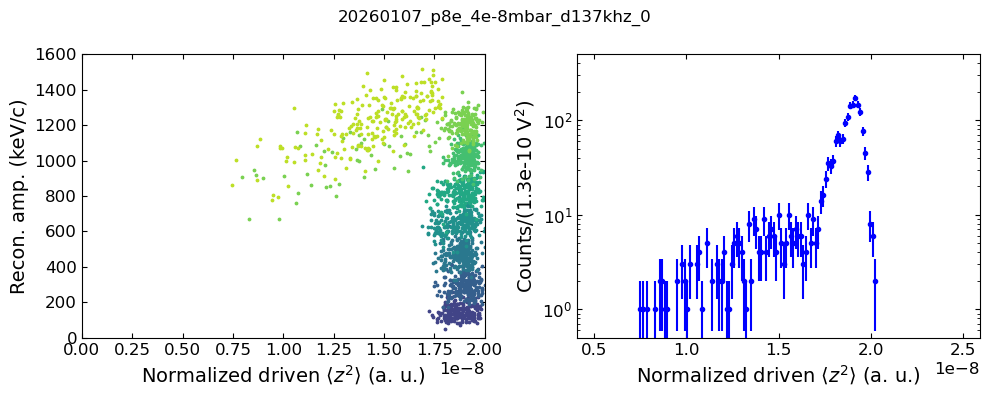

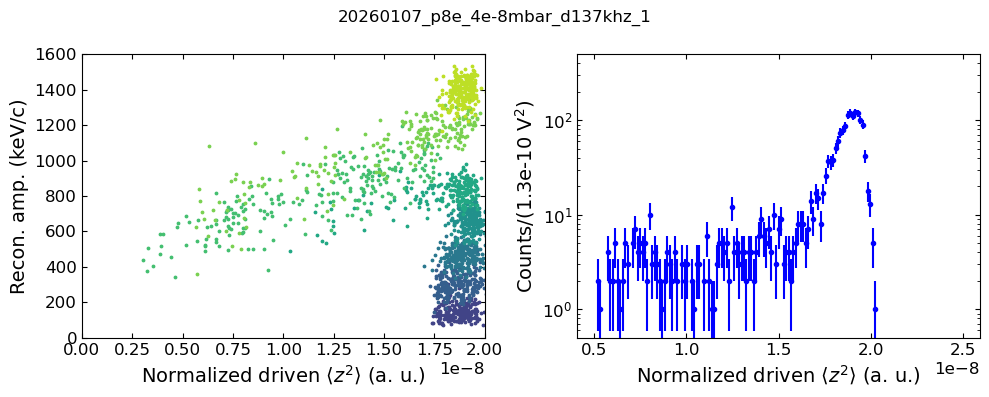

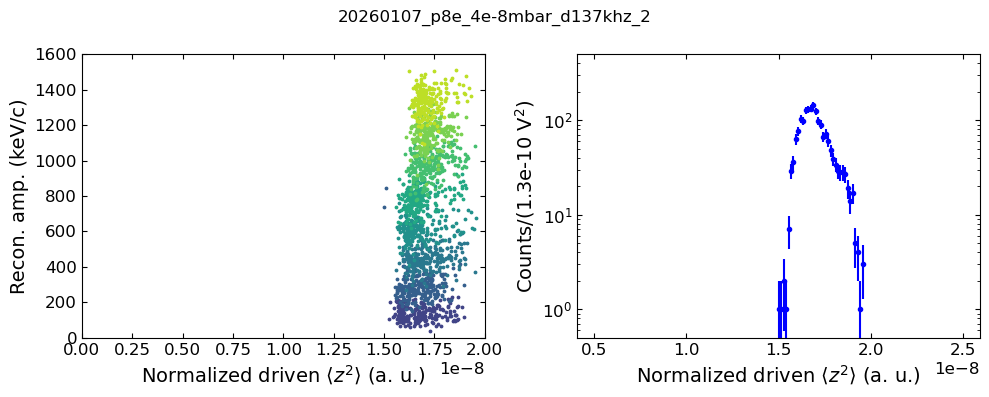

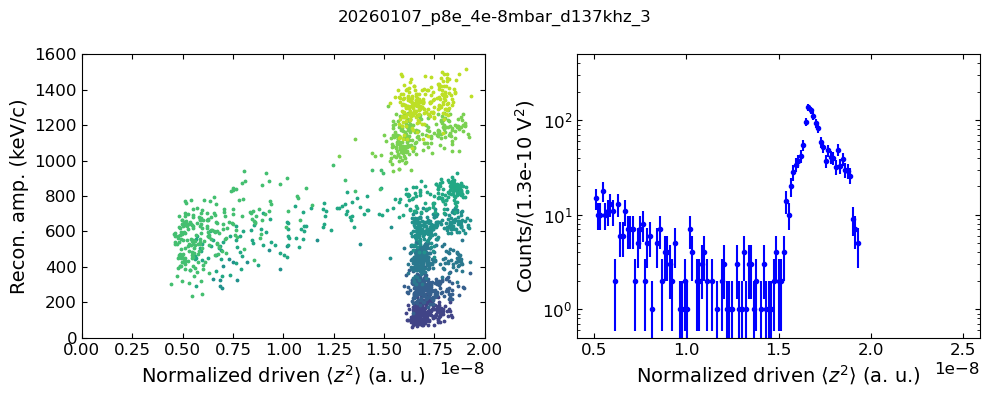

In [68]:
dataset_0 = '20260107_p8e_4e-8mbar_d137khz_0'
dataset_1 = '20260107_p8e_4e-8mbar_d137khz_1'
dataset_2 = '20260107_p8e_4e-8mbar_d137khz_2'
dataset_3 = '20260107_p8e_4e-8mbar_d137khz_3'

dataset_all = [dataset_0, dataset_1, dataset_2, dataset_3]
voltages = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]

bins = np.linspace(0.5e-8, 2.5e-8, 150)
bc = 0.5 * (bins[1:] + bins[:-1])
for dataset in dataset_all:
    amps_all, amps_noise, amps_noise_search, pulse_shapes_all, zz_pulses_all, drive_area_all, f_res_all = read_recon(voltages, dataset)

    fig, axes, bc, hh = plot_monitoring(dataset, drive_area_all, amps_all, f_res_all, drive_freq, ref_freq, amp2kev)

In [79]:
good_amps_all_datasets = []
good_pulse_shape_all_datasets = []

for dataset in dataset_all:
    amps_all, amps_noise, amps_noise_search, pulse_shapes_all, zz_pulses_all, drive_area_all, f_res_all = read_recon(voltages, dataset)
    good_amps_all, good_pulses_all = get_good_amps(amps_all, pulse_shapes_all, drive_area_all, f_res_all, 137000, 48500, 1.75e-8)
    good_amps_all_datasets.append(good_amps_all)
    good_pulse_shape_all_datasets.append(good_pulses_all)

_good_amps_all_datasets = []
_good_pulse_shape_all_datasets = []
for i in range(8):
    _amps = np.concatenate([good_amps_all_datasets[j][i] for j in range(4)])
    _pulses = np.concatenate([good_pulse_shape_all_datasets[j][i] for j in range(4)], axis=0)
    _good_amps_all_datasets.append(_amps)
    _good_pulse_shape_all_datasets.append(_pulses)

good_amps_all_datasets = _good_amps_all_datasets
good_pulse_shape_all_datasets = _good_pulse_shape_all_datasets

amp2keV: 6792.436870540769


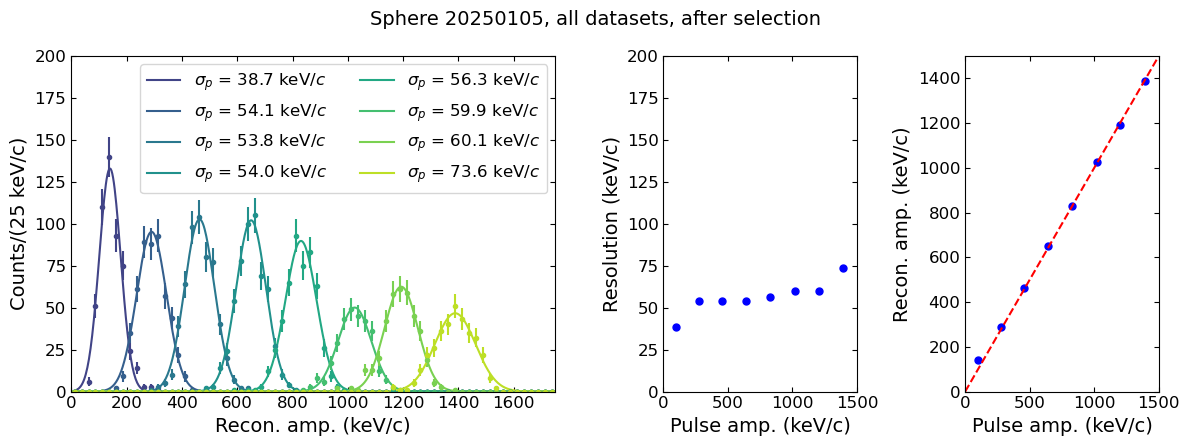

In [59]:
from scipy.optimize import curve_fit

def model_func(x, a):
    return a * x

amp2kev = 6792.86423779262
bins = np.arange(0, 3000, 25) / amp2kev
pulse_amp = np.asarray([99, 279, 456, 643, 824, 1018, 1202, 1395])

cmap = plt.colormaps.get_cmap('viridis')
colors = cmap(np.linspace(0.2, 0.9, 8))

fig, axes = plt.subplots(1, 3, figsize=(12, 4.5), width_ratios=[2.5, 1, 1])
hhs_good, bcs_good, gps_good = utils.fit_amps_gaus(good_amps_all_datasets, bins=bins, noise=False, return_bins=False)

xx = np.linspace(0, np.max(bcs[0]), 1000)
for i in range(8):
    axes[0].errorbar(bcs_good[i]*amp2kev, hhs_good[i], yerr=np.sqrt(hhs_good[i]), fmt='.', color=colors[i])
    axes[0].plot(xx*amp2kev, utils.gauss(xx, *gps_good[i]), label=fr'$\sigma_p$ = {gps_good[i][2]*amp2kev:.1f} keV/$c$', color=colors[i])

amp2kevs = pulse_amp / np.asarray(gps_good).T[1]
amp2kev = curve_fit(model_func, np.asarray(gps_good).T[1][2:], pulse_amp[2:])[0][0]
print(f'amp2keV: {amp2kev}')

axes[0].legend(ncol=2)
axes[0].set_xlim(0, 1750)
axes[0].set_ylim(0, 200)
axes[0].set_xlabel('Recon. amp. (keV/c)')
axes[0].set_ylabel('Counts/(25 keV/c)')

axes[1].plot(pulse_amp, np.asarray(gps_good).T[2]*amp2kev, 'b.', markersize=10)
axes[1].set_xlim(0, 1500)
axes[1].set_ylim(0, 200)
axes[1].set_xlabel('Pulse amp. (keV/c)')
axes[1].set_ylabel('Resolution (keV/c)')

axes[2].plot(pulse_amp, np.asarray(gps_good).T[1]*amp2kev, 'b.', markersize=10)
axes[2].plot(np.linspace(0, 1500, 50), np.linspace(0, 1500, 50), 'r--')
axes[2].set_xlim(0, 1500)
axes[2].set_ylim(0, 1500)
axes[2].set_xlabel('Pulse amp. (keV/c)')
axes[2].set_ylabel('Recon. amp. (keV/c)')

fig.suptitle('Sphere 20250105, all datasets, after selection', fontsize=14)
fig.tight_layout()

Measured effciency: [0.0019230769230769232, 0.44422700587084146, 0.9981884057971014, 1.0, 1.0, 1.0, 1.0, 1.0]
Fitted parameters: [2.88150446e+02 1.08156304e-02]


Text(0, 0.5, '5-$\\sigma_p$ signal efficiency')

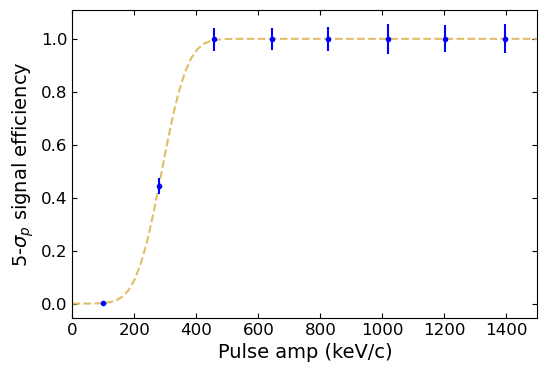

In [201]:
from scipy.special import erf
def func_eff(x, z, f):
    return 0.5 * erf((x - z) * f) + 0.5

def get_detection_efficiency(normalized_amps, sigmas, threshold=5):
    eff, eff_err = [], []
    for i, amps in enumerate(normalized_amps):
        count = np.count_nonzero(amps > threshold * sigmas[i])
        eff.append(count / amps.size)
        eff_err.append(np.sqrt(count) / amps.size)

    return eff, eff_err

sigma_p_amp = 60 / 6792.86423779262
signal_eff, signal_eff_err = get_detection_efficiency(good_amps_all_datasets, np.full(8, sigma_p_amp), 5)

popt, pcov = curve_fit(func_eff, pulse_amp, signal_eff, sigma=signal_eff_err, p0=[60, 0.001], maxfev=5000)
print(f'Measured effciency: {signal_eff}')
print(f'Fitted parameters: {popt}')

fig, ax = plt.subplots(figsize=(6, 4))

xx = np.linspace(0, 2000, 100)
ax.plot(xx, func_eff(xx, *popt), '--',label='Error function fit', color='#E1BE6A')

ax.errorbar(pulse_amp, signal_eff, yerr=signal_eff_err, color='b', fmt='.')

ax.set_xlim(0, 1500)

ax.set_xlabel('Pulse amp (keV/c)')
ax.set_ylabel(r'5-$\sigma_p$ signal efficiency')

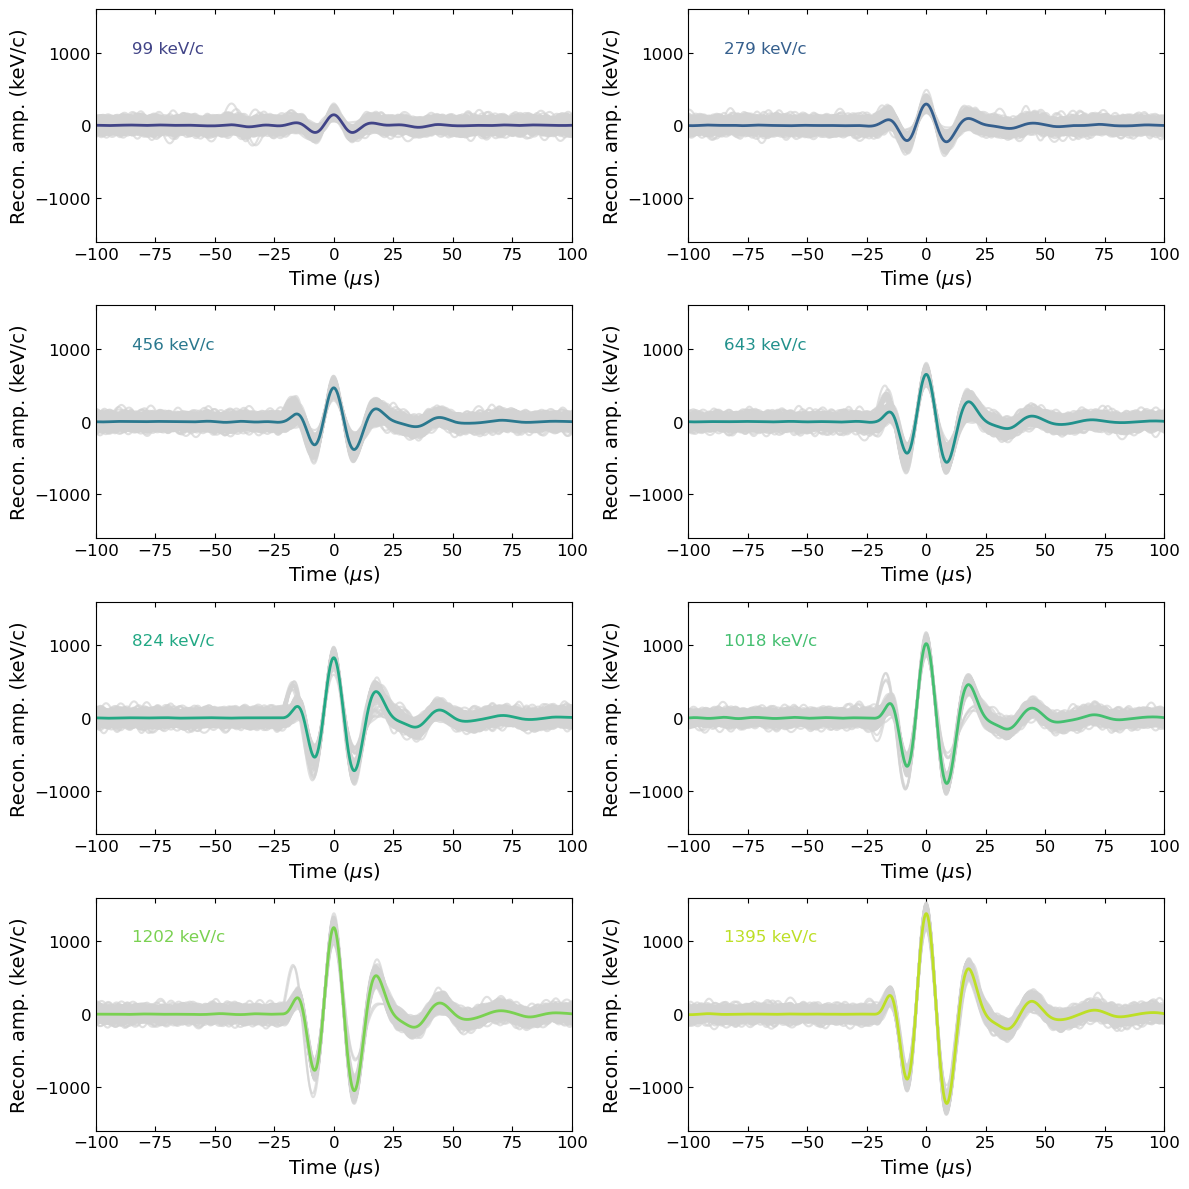

In [118]:
pulse_amp = np.asarray([99, 279, 456, 643, 824, 1018, 1202, 1395])
tt = 200e-9 * np.arange(3000)

fig, axes = plt.subplots(4 ,2, figsize=(12, 12))
for i, good_pulse in enumerate(good_pulse_shape_all_datasets):
    ax = axes.flatten()[i]
    
    for j in range(good_pulse.shape[0]):
        ax.plot(tt/1e-6-300, amp2kev*good_pulse[j], color='lightgray', alpha=0.7)

    ax.plot(tt/1e-6 - 300, amp2kev*np.mean(good_pulse, axis=0), color=colors[i], linewidth=2)

    ax.set_xlabel(r'Time ($\mu$s)')
    ax.set_ylabel(r'Recon. amp. (keV/c)')

    ax.text(-85, 1000, f'{pulse_amp[i]} keV/c', fontsize=12, color=colors[i])
    ax.set_xlim(-100, 100)
    ax.set_ylim(-1600, 1600)

fig.tight_layout()

In [110]:
pulse_shape_template_all = []
for i, good_pulse in enumerate(good_pulse_shape_all_datasets):
    pulse_shape_template_all.append(np.mean(good_pulse, axis=0))

np.savez(r'/Users/yuhan/work/nanospheres/gas_collisiions/data_processed/pulse_calibration/sphere_20260105_pulse_shape_template_combined.npz', 
         ps_2_5v=pulse_shape_template_all[0],
         ps_5v=pulse_shape_template_all[1],
         ps_7_5v=pulse_shape_template_all[2],
         ps_10v=pulse_shape_template_all[3],
         ps_12_5v=pulse_shape_template_all[4],
         ps_15v=pulse_shape_template_all[5],
         ps_17_5v=pulse_shape_template_all[6],
         ps_20v=pulse_shape_template_all[7],
         pulse_amp_kev=pulse_amp,
         amp2kev=amp2kev)

#### Calculate the chi2 of the calibration pulses

In [ ]:
def get_normalized_template(sphere, bounds=(1250, 1750), downsampled=False):
    pulse_shape_file = np.load(rf'/Users/yuhan/work/nanospheres/gas_collisiions/data_processed/pulse_calibration/{sphere}_pulse_shape_template_combined.npz')
    pulse_shape_template = pulse_shape_file['ps_20v']

    normalized_template = pulse_shape_template / np.max(pulse_shape_template)

     # Take the central values around the peak
    ret = normalized_template[bounds[0]:bounds[1]]

    # Downsample to 500 kHz (so the 200 us template has 100 indices)
    if downsampled:
        ret_downsampled = decimate(ret, 10)
        return ret_downsampled / np.max(ret_downsampled)
    else:
        return ret

def calc_chisquares_pulse(pulse_shapes, normalized_template, bounds, sigma_amp):
    amp_idx = 1500

    ret = np.empty(pulse_shapes.shape[0])
    for i, pulse_shape in enumerate(pulse_shapes):
        amp = pulse_shape[amp_idx]

        waveform = pulse_shape[bounds[0] : bounds[1]]
        # Amplitude can be negative so no need to adjust for polarity
        template_scaled = amp * normalized_template

        # Sigma should be in amplitude (not keV)
        ret[i] = np.sum( ((waveform - template_scaled)/sigma_amp)**2 )
    return ret

In [122]:
sphere = 'sphere_20260105'
normalized_template = get_normalized_template(sphere, bounds=(1250, 1750), downsampled=False)


In [137]:
sigma_p_amp = 60 / 6792.86423779262
chi2_pulse_all = []
for i, good_pulses in enumerate(good_pulse_shape_all_datasets):
    chi2 = calc_chisquares_pulse(good_pulses, normalized_template, (1250, 1750), sigma_p_amp)
    chi2_pulse_all.append(chi2)

Text(0.5, 1.0, 'Sphere 20260105, all calibration')

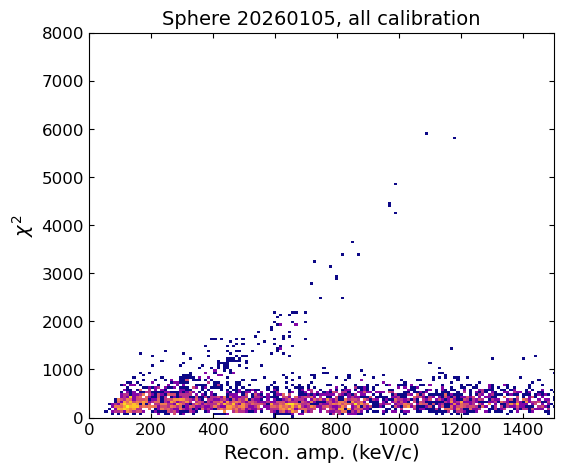

In [160]:
import matplotlib.colors as colors

xbins = np.linspace(0, 2000, 200)
ybins = np.linspace(0, 10000, 200)

_good_amps_all_datasets = np.concatenate(good_amps_all_datasets)
_chi2_all_datasets = np.concatenate(chi2_pulse_all)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

hh, _, _ = np.histogram2d(x=np.abs(_good_amps_all_datasets)*amp2kev, y=_chi2_all_datasets, bins=(xbins, ybins))
pc = ax.pcolormesh(xbins, ybins, hh.T, norm=colors.LogNorm(), cmap='plasma')

ax.set_ylim(0, 8000)
ax.set_xlim(0, 1500)
ax.set_xlabel(r'Recon. amp. (keV/c)', fontsize=14)
ax.set_ylabel(r'$\chi^2$', fontsize=14)
ax.set_title(f'Sphere 20260105, all calibration')